In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import skimage
from skimage.io import imread , imsave, imread_collection 

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder,StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

%matplotlib inline


In [7]:
test_feat = pd.read_csv('data/test_features.csv')

In [8]:
test_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3982 entries, 0 to 3981
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 26.6+ MB


In [9]:
test_feat.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [10]:
train_drug = pd.read_csv('data/train_drug.csv')

In [11]:
train_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sig_id   23814 non-null  object
 1   drug_id  23814 non-null  object
dtypes: object(2)
memory usage: 372.2+ KB


In [12]:
train_drug.head()

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


In [13]:
train_feat = pd.read_csv('data/train_features.csv')

In [14]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [15]:
train_feat.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train_targets_nonscored = pd.read_csv('data/train_targets_nonscored.csv')

In [20]:
train_targets_nonscored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 403 entries, sig_id to xiap_inhibitor
dtypes: int64(402), object(1)
memory usage: 73.2+ MB


In [21]:
train_targets_nonscored.head()

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
train_targets_scored = pd.read_csv('data/train_targets_scored.csv')

In [23]:
train_targets_scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


In [24]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
train_targets_nonscored.iloc[4,:].values

array(['id_001626bd3', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [62]:
if 1 not in train_targets_nonscored.values:
    print("\nThis value not exists in Dataframe")
else:
    print("\nThis value exists in Dataframe")


This value exists in Dataframe


In [63]:
train_targets_nonscored[train_targets_nonscored == 1].sum()

sig_id                                   0.0
abc_transporter_expression_enhancer      6.0
abl_inhibitor                           24.0
ace_inhibitor                           91.0
acetylcholine_release_enhancer           6.0
                                        ... 
voltage-gated_sodium_channel_blocker    18.0
wdr5_mll_interaction_inhibitor           6.0
wnt_agonist                              0.0
xanthine_oxidase_inhibitor              24.0
xiap_inhibitor                          24.0
Length: 403, dtype: float64

In [92]:
train_targets_scored[train_targets_scored == 1].sum()

sig_id                                     0.0
5-alpha_reductase_inhibitor               17.0
11-beta-hsd1_inhibitor                    18.0
acat_inhibitor                            24.0
acetylcholine_receptor_agonist           190.0
                                         ...  
ubiquitin_specific_protease_inhibitor      6.0
vegfr_inhibitor                          170.0
vitamin_b                                 26.0
vitamin_d_receptor_agonist                39.0
wnt_inhibitor                             30.0
Length: 207, dtype: float64

It seems that in train_targets_scored, some values are 1, it means the corresponding sample_id is classified as that class. Please note one sample can be classified into more than 1 classes, it can also be classified into no class, i.e all values are 0. In train_targets_nonscored, it is the same, some values are 0, and some values are 1, so what's the difference???

train_feat will be train data, test_feat will be test data. Check missing value:

In [66]:
train_feat.isna().sum().sum()

0

In [67]:
test_feat.isna().sum().sum()

0

Good, no missing values.

check categorical and numerical features:

In [68]:
train_feat_cat = train_feat.select_dtypes(include=['object'])
train_feat_num = train_feat.select_dtypes(exclude=['object'])
print('Numerical features',len(train_feat_num.columns))
print('Categorical features',len(train_feat_cat.columns))
print(train_feat_cat.columns)

Numerical features 873
Categorical features 3
Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')


Compound features:

In [69]:
test_feat_cat = test_feat.select_dtypes(include=['object'])
test_feat_num = test_feat.select_dtypes(exclude=['object'])
print('Numerical features',len(test_feat_num.columns))
print('Categorical features',len(test_feat_cat.columns))
print(test_feat_cat.columns)

Numerical features 873
Categorical features 3
Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')


In [76]:
train_feat.cp_time.value_counts()

48    8250
72    7792
24    7772
Name: cp_time, dtype: int64

In [80]:
8250/(8250+7792+7772), 7792/(8250+7792+7772), 7772/(8250+7792+7772)

(0.34643487024439407, 0.32720248593264467, 0.32636264382296126)

In [73]:
train_feat.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [81]:
21948/(21948+1866), 1866/(21948+1866)

(0.9216427311665407, 0.07835726883345931)

In [74]:
train_feat.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

In [82]:
12147/(12147+11667), 11667/(12147+11667)

(0.5100781053162006, 0.48992189468379943)

In [77]:
test_feat.cp_time.value_counts()

48    1377
72    1305
24    1300
Name: cp_time, dtype: int64

In [83]:
1377/(1377+1305+1300), 1305/(1377+1305+1300), 1300/(1377+1305+1300)

(0.34580612757408336, 0.3277247614264189, 0.3264691109994977)

In [78]:
test_feat.cp_type.value_counts()

trt_cp         3624
ctl_vehicle     358
Name: cp_type, dtype: int64

In [84]:
3624/(3624+358), 358/(3624+358)

(0.910095429432446, 0.08990457056755399)

In [79]:
test_feat.cp_dose.value_counts()

D1    2027
D2    1955
Name: cp_dose, dtype: int64

In [85]:
2027/(2027+1955), 1955/(2027+1955)

(0.5090406830738322, 0.49095931692616773)

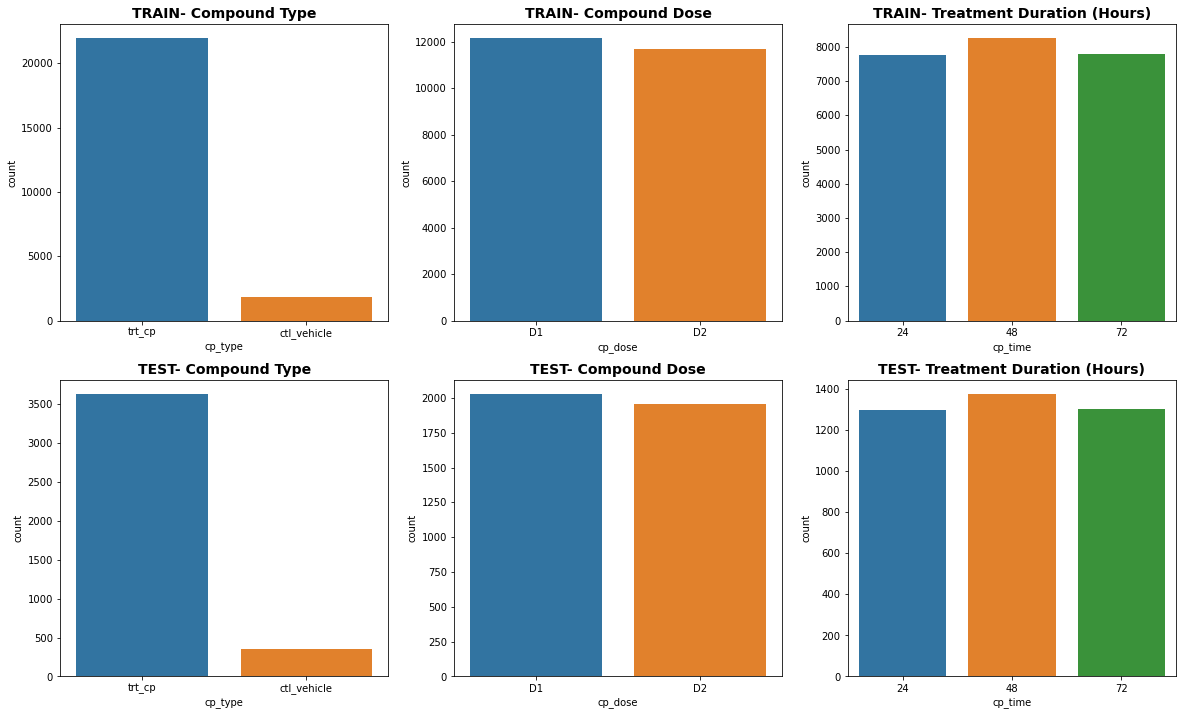

In [87]:
fig, ax =plt.subplots(2,3, figsize=(20,12))
sns.countplot(x='cp_type', data=train_feat,ax=ax[0,0])
ax[0,0].set_title('TRAIN- Compound Type', fontsize=14, weight='bold')
sns.countplot(x='cp_dose', data=train_feat,ax=ax[0,1])
ax[0,1].set_title('TRAIN- Compound Dose', fontsize=14, weight='bold')
sns.countplot(x='cp_time', data=train_feat,ax=ax[0,2])
ax[0,2].set_title('TRAIN- Treatment Duration (Hours)', fontsize=14, weight='bold')
sns.countplot(x='cp_type', data=test_feat,ax=ax[1,0])
ax[1,0].set_title('TEST- Compound Type', fontsize=14, weight='bold')
sns.countplot(x='cp_dose', data=test_feat,ax=ax[1,1])
ax[1,1].set_title('TEST- Compound Dose', fontsize=14, weight='bold')
sns.countplot(x='cp_time', data=test_feat,ax=ax[1,2])
ax[1,2].set_title('TEST- Treatment Duration (Hours)', fontsize=14, weight='bold')
plt.show()

Distributions are similar in train and test data.

Gene features:

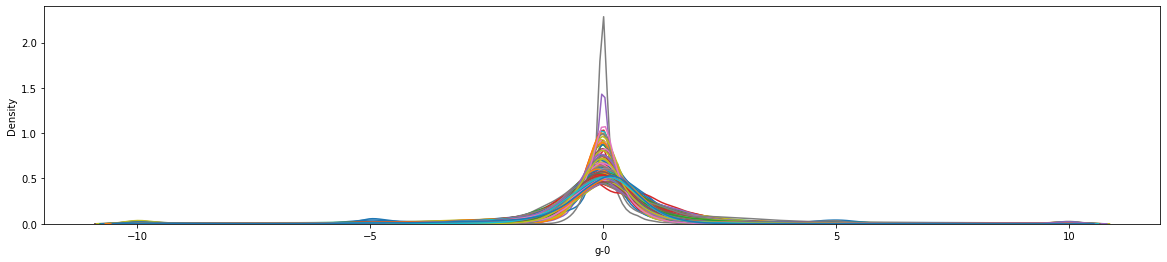

In [89]:
plt.rc('figure', figsize=(20, 4))
fig.suptitle('Gene Distributions G-0 to G-771', fontsize=16)
genes = list(range(0, 771))
for gene in genes:
    sns.kdeplot(data=train_feat['g-'+ str(gene)], shade=False, legend=False)
plt.show()

Cell Features:

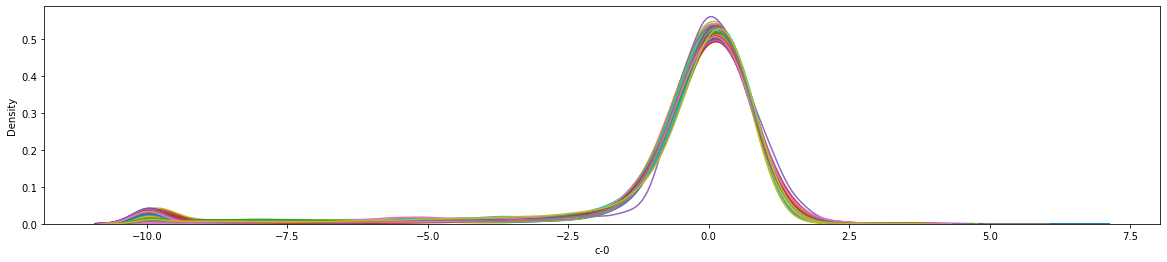

In [90]:
plt.rc('figure', figsize=(20, 4))
fig.suptitle('Cell Distributions C-0 to C-99', fontsize=16)
cells = list(range(0, 99))
for cell in cells:
    sns.kdeplot(data=train_feat['c-'+ str(cell)], shade=False, legend=False)
plt.show()

Convert all compound features into numerical 

correlation between features:

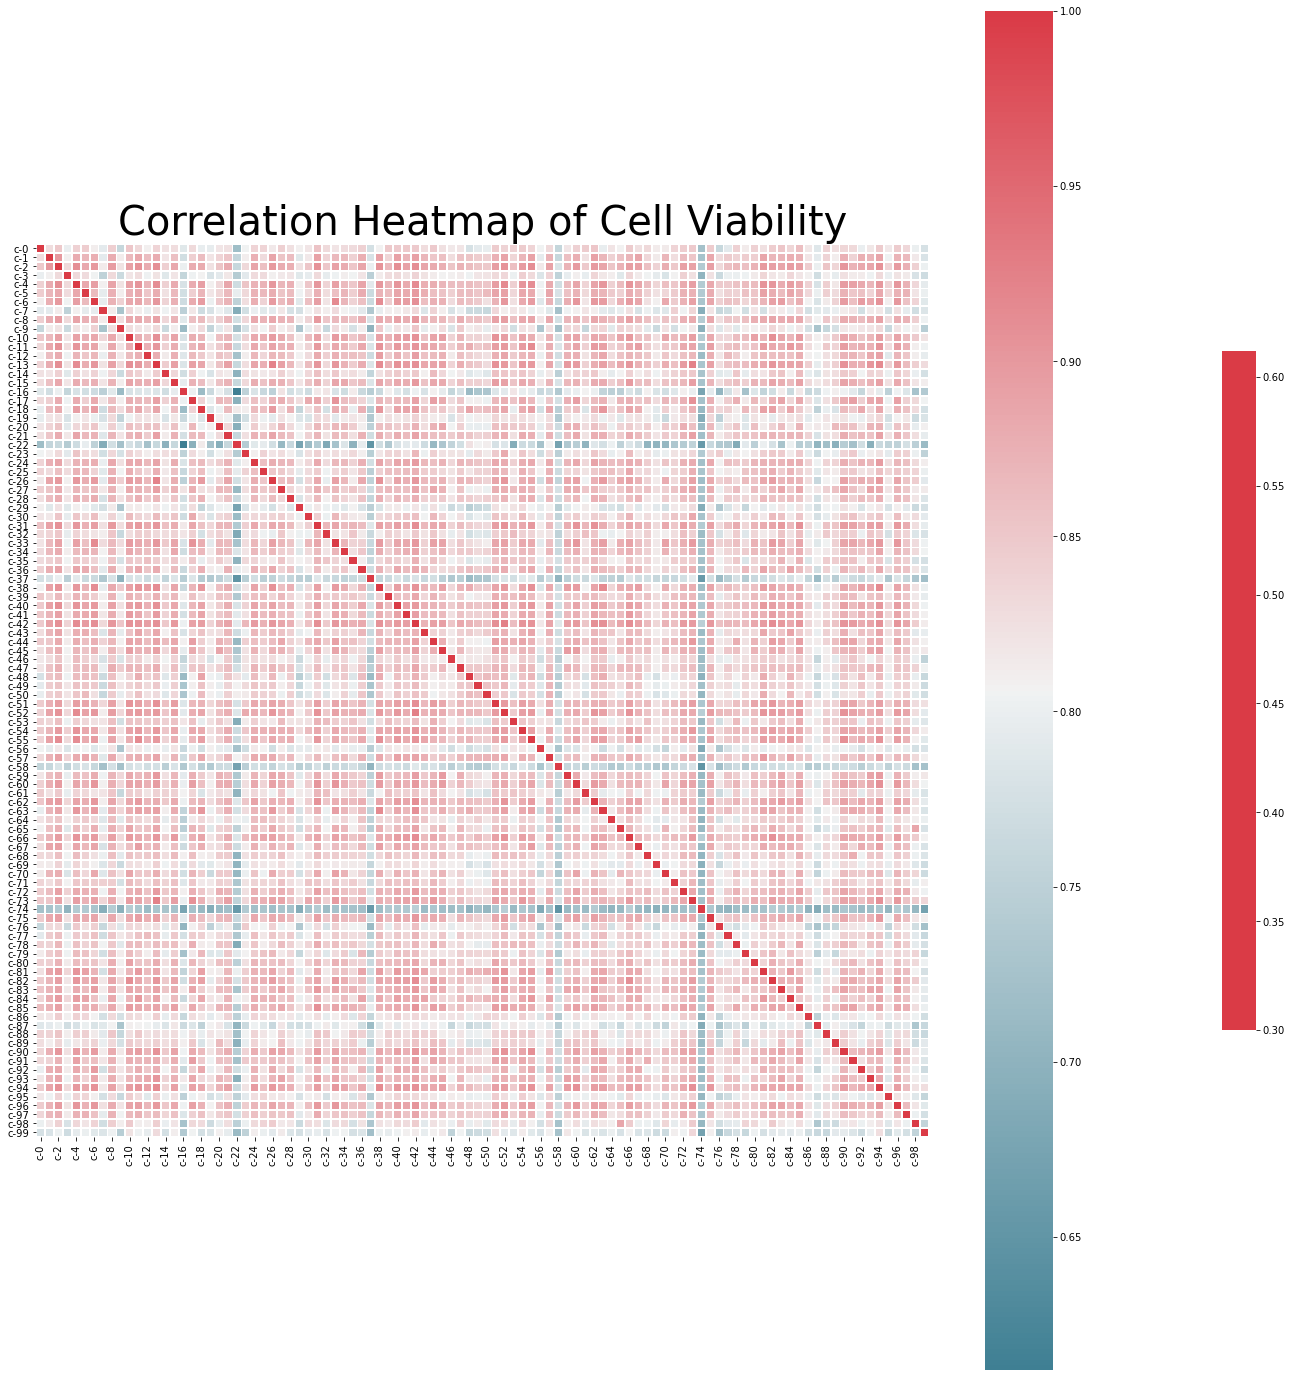

In [201]:
#Correlation matrix for cell viability
cell = train_feat.loc[:, train_feat.columns.str.startswith('c-')]
corr = cell.corr(method='pearson')

fig, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

ax = sns.heatmap(corr, linewidths=0.8, cmap=cmap)
plt.title('Correlation Heatmap of Cell Viability', fontsize=40)
plt.savefig('images/cell_corr.jpg')

There are strong correlations between cell viability variables. Can use PCA for dimensionality reduction, and ensure our variables are independent of each other.


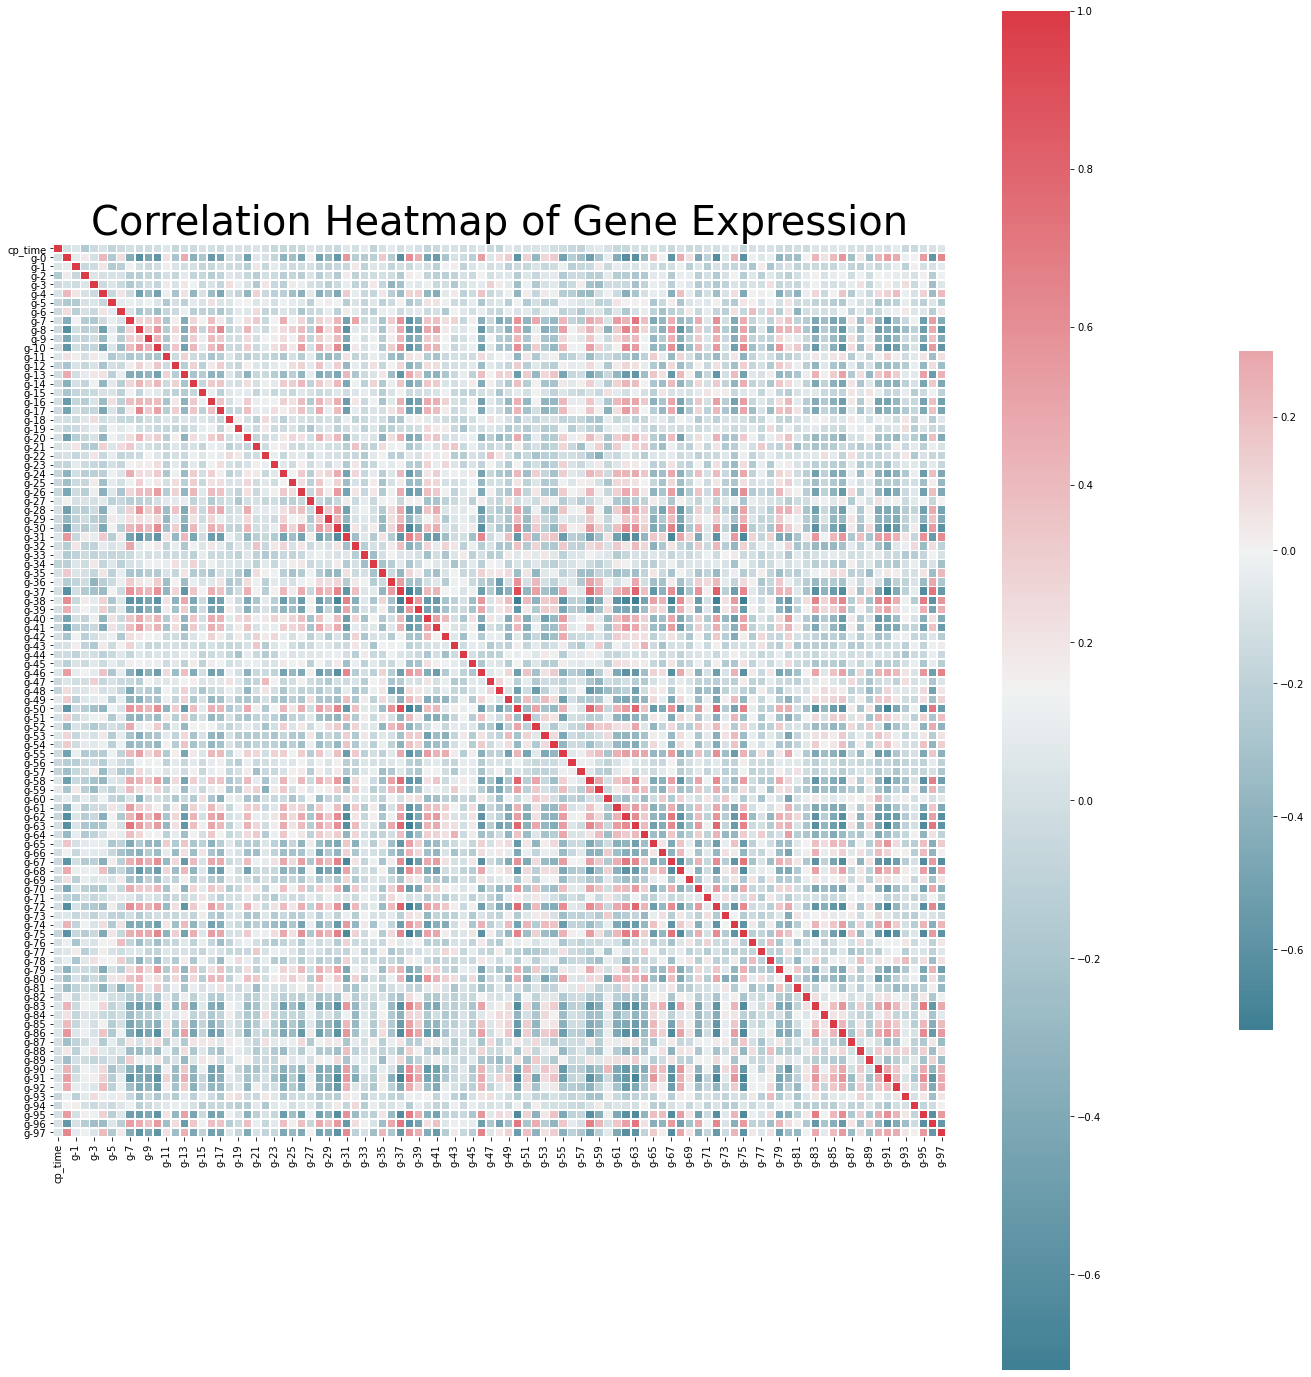

In [206]:
# for clarity, only take first 100 labels
gene = train_feat.iloc[:, :100]

corr = gene.corr(method='pearson')

fig, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

ax = sns.heatmap(corr,linewidths=0.8,cmap=cmap)
plt.title('Correlation Heatmap of Gene Expression', fontsize=40)
plt.savefig('images/gene_corr.jpg')

Gene expression variables have too mnay columns, so choose the first 100 columns to plot the correlation heatmap. There are also some correlations between different gene expressions, though not as strong as between cell viability.

Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

Check to see if there are correlations between different labels.

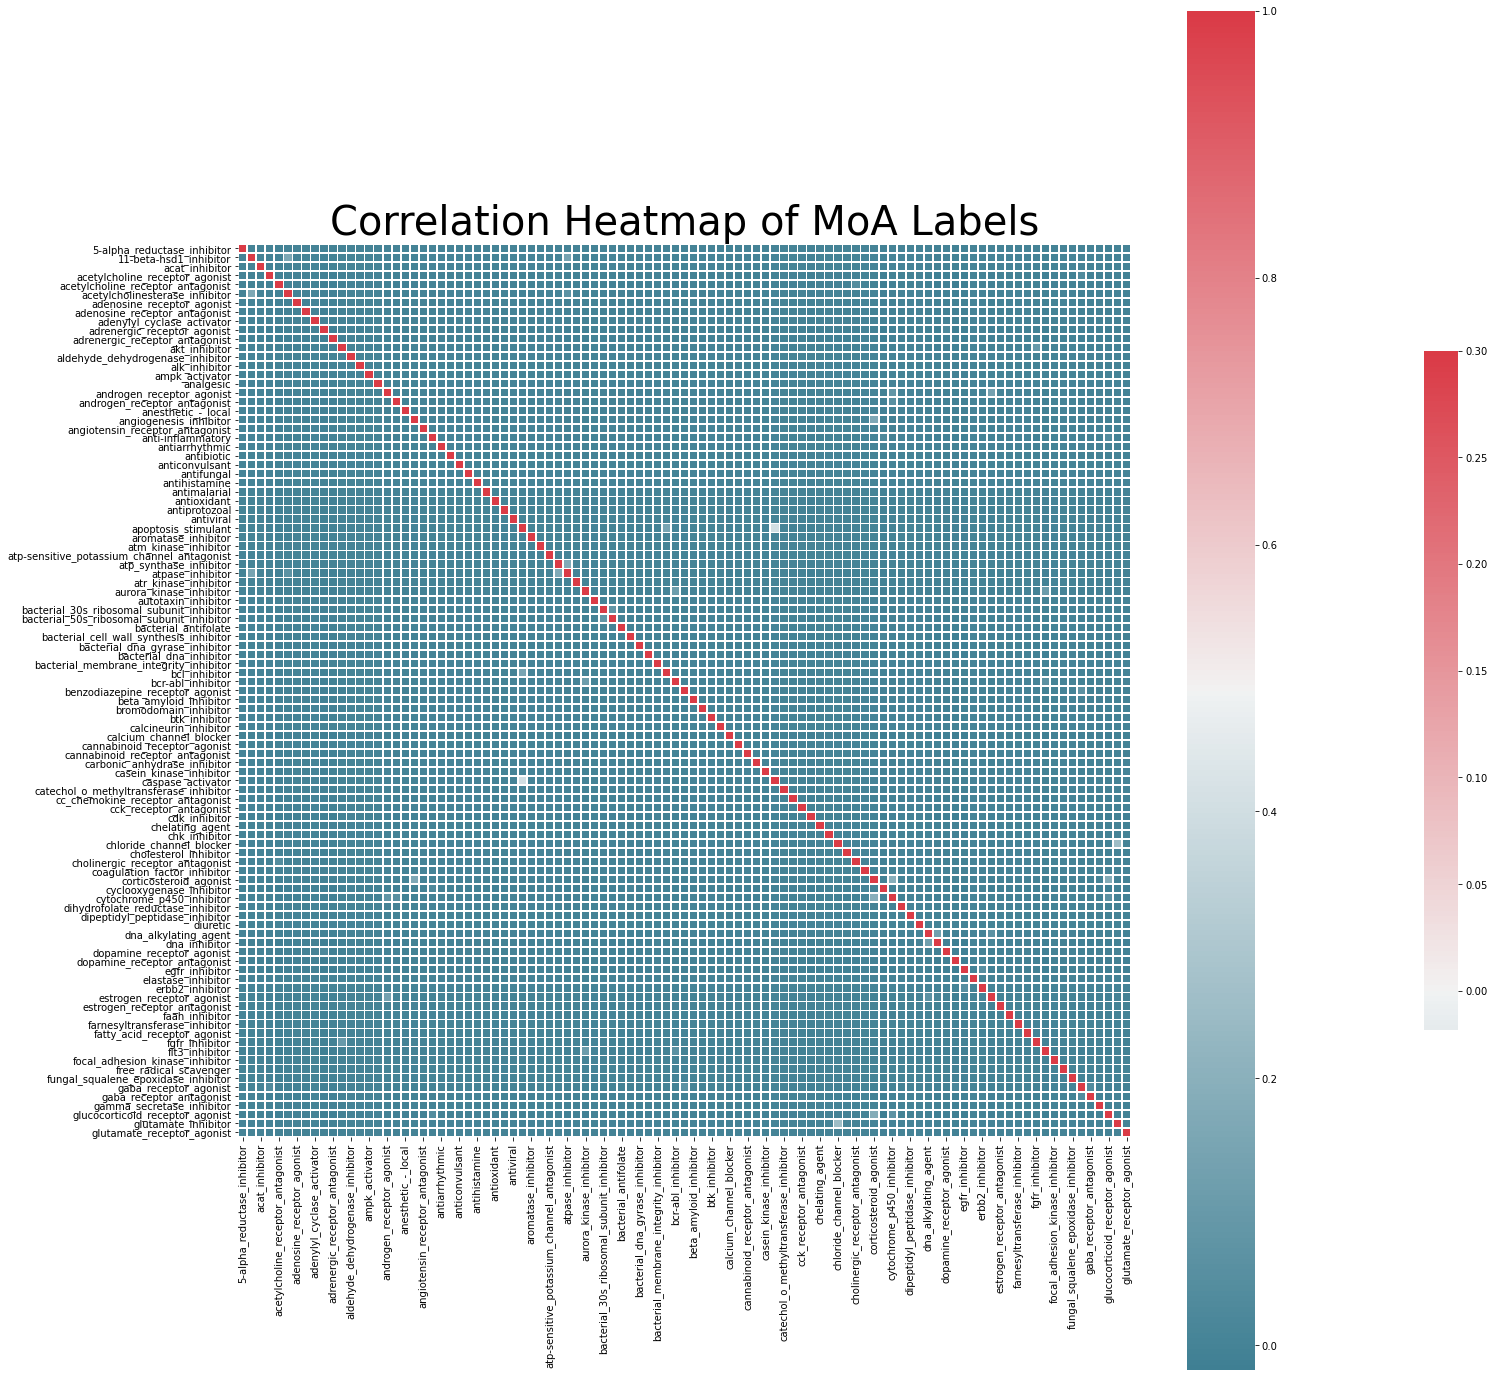

In [200]:
# for clarity, only take first 100 labels
moa = train_targets_scored.iloc[:, :100]
corr = moa.corr(method='pearson')

fig, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

ax = sns.heatmap(corr,linewidths=0.8,cmap=cmap)
plt.title('Correlation Heatmap of MoA Labels', fontsize=40)
plt.savefig('images/moa_corr.jpg')

There is no correlation between MoAs, they are independent to each other.

In [193]:
# #Correlation matrix for gene expression
# gene = train_feat.loc[:, train_feat.columns.str.startswith('g-')]
# corr = gene.corr(method='pearson')

# fig, ax = plt.subplots(figsize=(25, 25))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.8, cbar_kws={"shrink": .5})

# ax = sns.heatmap(corr, linewidths=0.8, cmap=cmap)
# plt.savefig('images/gene_corr.jpg')

In [93]:
train_feat.cp_time = train_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
train_feat = pd.get_dummies(train_feat, columns=['cp_type'], prefix="cp_type", drop_first=True)
train_feat = pd.get_dummies(train_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

test_feat.cp_time = test_feat.cp_time.map({24: 1, 48: 2, 72: 3}).astype(int)
test_feat = pd.get_dummies(test_feat, columns=["cp_type"], prefix="cp_type", drop_first=True)
test_feat = pd.get_dummies(test_feat, columns=["cp_dose"], prefix="cp_dose", drop_first=True)

A base MLP model: 

In [96]:
X = train_feat.drop('sig_id', axis=1).values
y = train_targets_scored.drop('sig_id', axis=1).values



In [97]:
X.shape, y.shape

((23814, 875), (23814, 206))

In [98]:
X_holdout = test_feat.drop('sig_id', axis=1).values
X_holdout.shape

(3982, 875)

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=1)


In [107]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((17860, 875), (17860, 206), (5954, 875), (5954, 206))

In [186]:
# Need to define the log-loss metric required by the competition, see formula here:
# https://www.kaggle.com/c/lish-moa/overview/evaluation

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0.001, 0.999)
    return -backend.mean(y_true*backend.log(y_pred) + (1-y_true)*backend.log(1-y_pred))

In [188]:
def build_model(n_cols):
    model = Sequential()
    model.add(Dense(64,activation='relu', input_shape=(n_cols,)))
    #model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128,activation='relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model  

n_cols = X.shape[1]
base_mlp = build_model(n_cols)
base_mlp.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 64)                56064     
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 206)               26574     
Total params: 91,470
Trainable params: 91,214
Non-trainable params: 256
_______________________________________________

In [194]:
earlystp_base_mlp = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/base_mlp'
checkpoint_base_mlp = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_base_mlp = base_mlp.fit(
    X_train, y_train, batch_size=32,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[checkpoint_base_mlp, earlystp_base_mlp])

base_mlp.save('models/base_mlp_complete')

Epoch 1/100
559/559 [==============================] - 5s 5ms/step - loss: 0.3729 - logloss: 0.3721 - val_loss: 0.0232 - val_logloss: 0.0205

Epoch 00001: loss improved from inf to 0.16262, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 2/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0234 - logloss: 0.0207 - val_loss: 0.0219 - val_logloss: 0.0189

Epoch 00002: loss improved from 0.16262 to 0.02310, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 3/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0221 - logloss: 0.0191 - val_loss: 0.0207 - val_logloss: 0.0176

Epoch 00003: loss improved from 0.02310 to 0.02193, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 4/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0212 - logloss: 0.0181 - val_loss: 0.0201 - val_logloss: 0.0170

Epoch 0000

INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 30/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0128 - logloss: 0.0093 - val_loss: 0.0229 - val_logloss: 0.0175

Epoch 00030: loss improved from 0.01318 to 0.01306, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 31/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0127 - logloss: 0.0091 - val_loss: 0.0234 - val_logloss: 0.0179

Epoch 00031: loss improved from 0.01306 to 0.01286, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 32/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0126 - logloss: 0.0090 - val_loss: 0.0231 - val_logloss: 0.0177

Epoch 00032: loss improved from 0.01286 to 0.01280, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 33/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0126 - lo

Epoch 59/100
559/559 [==============================] - 2s 4ms/step - loss: 0.0108 - logloss: 0.0070 - val_loss: 0.0259 - val_logloss: 0.0186

Epoch 00059: loss improved from 0.01104 to 0.01101, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 60/100
559/559 [==============================] - 3s 5ms/step - loss: 0.0107 - logloss: 0.0069 - val_loss: 0.0261 - val_logloss: 0.0186

Epoch 00060: loss improved from 0.01101 to 0.01094, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 61/100
559/559 [==============================] - 2s 4ms/step - loss: 0.0107 - logloss: 0.0070 - val_loss: 0.0261 - val_logloss: 0.0187

Epoch 00061: loss improved from 0.01094 to 0.01090, saving model to models\base_mlp
INFO:tensorflow:Assets written to: models\base_mlp\assets
Epoch 62/100
559/559 [==============================] - 2s 4ms/step - loss: 0.0108 - logloss: 0.0070 - val_loss: 0.0259 - val_logloss: 0.0185

Ep

559/559 [==============================] - 2s 4ms/step - loss: 0.0099 - logloss: 0.0061 - val_loss: 0.0274 - val_logloss: 0.0189

Epoch 00092: loss did not improve from 0.01009
INFO:tensorflow:Assets written to: models/base_mlp_complete\assets


In [212]:
y_val_pred = base_mlp.predict(X_val)
y_val_pred[1]

array([8.25643539e-04, 1.22338124e-05, 7.29972124e-03, 1.51732165e-05,
       1.89512968e-04, 2.57187876e-05, 1.00472569e-03, 3.93441319e-03,
       3.71158123e-04, 2.33519077e-03, 5.21210609e-07, 1.40234060e-05,
       3.50117683e-04, 1.85674429e-03, 9.55820084e-04, 1.47613883e-03,
       2.45940828e-05, 1.23445170e-05, 4.88847494e-04, 5.36140578e-05,
       8.95980411e-05, 6.84452057e-03, 6.86702132e-03, 3.64955959e-05,
       8.46118128e-05, 1.41471624e-04, 9.91612673e-04, 1.19680166e-03,
       3.04069204e-06, 1.13397749e-04, 1.64750218e-03, 7.21617689e-05,
       5.37157059e-04, 7.97599554e-04, 6.50614500e-04, 4.10735607e-04,
       5.53513337e-06, 1.66642666e-03, 1.76370144e-04, 1.39677525e-03,
       2.55480409e-03, 3.39198112e-03, 1.45188424e-05, 8.57055187e-04,
       5.14712337e-06, 7.02635270e-06, 6.05794667e-05, 4.80536710e-06,
       6.07103109e-04, 1.93950534e-03, 3.13669443e-04, 4.28345799e-03,
       1.14650007e-04, 1.46460533e-03, 1.26434670e-05, 8.20371351e-05,
      

In [162]:
X_train

array([[ 1.    , -0.6654,  0.8294, ...,  0.9438,  1.    ,  1.    ],
       [ 3.    ,  0.4327, -0.3986, ...,  0.0719,  1.    ,  0.    ],
       [ 3.    ,  0.5965, -0.9577, ...,  0.0074,  1.    ,  0.    ],
       ...,
       [ 2.    ,  0.148 , -0.7907, ..., -0.0585,  1.    ,  0.    ],
       [ 2.    , -0.1265,  0.3539, ..., -0.1108,  1.    ,  1.    ],
       [ 3.    , -0.134 ,  0.3848, ..., -1.758 ,  1.    ,  1.    ]])

In [161]:
sample_size = X_train.shape[0] # number of samples in train set
col_num  = X_train.shape[1] # number of features in train set
input_dimension = 1            # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, col_num, input_dimension)
print("After reshape X_train shape:\n", X_train_reshaped.shape)
#print("1 Sample shape:\n", X_train_reshaped[0].shape)
#print("An example sample:\n", X_train_reshaped[0])
#X_train_reshaped

After reshape X_train shape:
 (17860, 875, 1)


array([[[ 1.    ],
        [-0.6654],
        [ 0.8294],
        ...,
        [ 0.9438],
        [ 1.    ],
        [ 1.    ]],

       [[ 3.    ],
        [ 0.4327],
        [-0.3986],
        ...,
        [ 0.0719],
        [ 1.    ],
        [ 0.    ]],

       [[ 3.    ],
        [ 0.5965],
        [-0.9577],
        ...,
        [ 0.0074],
        [ 1.    ],
        [ 0.    ]],

       ...,

       [[ 2.    ],
        [ 0.148 ],
        [-0.7907],
        ...,
        [-0.0585],
        [ 1.    ],
        [ 0.    ]],

       [[ 2.    ],
        [-0.1265],
        [ 0.3539],
        ...,
        [-0.1108],
        [ 1.    ],
        [ 1.    ]],

       [[ 3.    ],
        [-0.134 ],
        [ 0.3848],
        ...,
        [-1.758 ],
        [ 1.    ],
        [ 1.    ]]])

In [126]:
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], input_dimension)
print("After reshape train data set shape:\n", X_val_reshaped.shape)

After reshape train data set shape:
 (5954, 875, 1)


In [128]:
# no need to reshape y_train, causes trouble!!!
y_train_reshaped = y_train.reshape(y_train.shape[0], y_train.shape[1], input_dimension)
print("After reshape Y_train shape:\n", y_train_reshaped.shape)

After reshape Y_train shape:
 (17860, 206, 1)


In [129]:
# no need to reshape y_val, causes trouble!!!
y_val_reshaped = y_val.reshape(y_val.shape[0], y_val.shape[1], input_dimension)
print("After reshape train data set shape:\n", y_val_reshaped.shape)

After reshape train data set shape:
 (5954, 206, 1)


In [203]:
def build_conv1D_model(n_cols):

    model = keras.Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_cols, 1)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))
    
    model.add(keras.layers.Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(keras.layers.Dense(206, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

    return model

n_cols = X_train_reshaped.shape[1]
base_conv1D = build_conv1D_model(n_cols)
base_conv1D.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 873, 32)           128       
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 871, 32)           3104      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 869, 64)           6208      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 434, 64)           0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 434, 64)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 27776)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)              

In [204]:
earlystp_base_conv1D = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/base_conv1D'
checkpoint_base_conv1D = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

history_base_covn1D = base_conv1D.fit(
    X_train_reshaped, y_train, batch_size=32,
    validation_data=(X_val_reshaped, y_val),
    epochs=30,
    callbacks=[checkpoint_base_conv1D, earlystp_base_conv1D])

base_conv1D.save('models/base_conv1D_complete')

Epoch 1/30
559/559 [==============================] - 89s 157ms/step - loss: 0.1211 - logloss: 0.1173 - val_loss: 0.0217 - val_logloss: 0.0185

Epoch 00001: loss improved from inf to 0.04913, saving model to models\base_conv1D
INFO:tensorflow:Assets written to: models\base_conv1D\assets
Epoch 2/30
559/559 [==============================] - 85s 153ms/step - loss: 0.0233 - logloss: 0.0199 - val_loss: 0.0207 - val_logloss: 0.0176

Epoch 00002: loss improved from 0.04913 to 0.02298, saving model to models\base_conv1D
INFO:tensorflow:Assets written to: models\base_conv1D\assets
Epoch 3/30
559/559 [==============================] - 88s 157ms/step - loss: 0.0213 - logloss: 0.0179 - val_loss: 0.0205 - val_logloss: 0.0170

Epoch 00003: loss improved from 0.02298 to 0.02130, saving model to models\base_conv1D
INFO:tensorflow:Assets written to: models\base_conv1D\assets
Epoch 4/30
559/559 [==============================] - 89s 160ms/step - loss: 0.0203 - logloss: 0.0169 - val_loss: 0.0200 - val_l

Epoch 29/30
559/559 [==============================] - 106s 190ms/step - loss: 0.0099 - logloss: 0.0056 - val_loss: 0.0301 - val_logloss: 0.0191

Epoch 00029: loss improved from 0.00999 to 0.00988, saving model to models\base_conv1D
INFO:tensorflow:Assets written to: models\base_conv1D\assets
Epoch 30/30
559/559 [==============================] - 109s 196ms/step - loss: 0.0096 - logloss: 0.0054 - val_loss: 0.0286 - val_logloss: 0.0193

Epoch 00030: loss improved from 0.00988 to 0.00977, saving model to models\base_conv1D
INFO:tensorflow:Assets written to: models\base_conv1D\assets
INFO:tensorflow:Assets written to: models/base_conv1D_complete\assets


Seems conv1D is not better than MLP.

Applying PCA to reduce dimensionality using MLP model.

In [219]:
# Try to find out optimal number of principal components
log_loss_score =[]

for i in range(80, 600, 20):
    print("Principal Components: ", i)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.25, shuffle=True, random_state=1)

    n_cols = X_pca_train.shape[1]
    
    earlystp_pca_mlp = EarlyStopping(monitor='loss', patience=5)
    filepath = 'models/pca_mlp'
    checkpoint_pca_mlp = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

    model_pca_mlp = build_model(n_cols)
    history_pca_mlp = model_pca_mlp.fit(
        X_pca_train, y_train, batch_size=32,
        validation_data=(X_pca_val, y_val),
        epochs=50,
        callbacks=[checkpoint_pca_mlp, earlystp_pca_mlp])
    
    score = model_pca_mlp.evaluate(X_pca_val, y_val, verbose=0)
    log_loss_score.append([i, score[1]])


Principal Components:  80
Epoch 1/50
559/559 [==============================] - 3s 4ms/step - loss: 0.3793 - logloss: 0.3785 - val_loss: 0.0225 - val_logloss: 0.0197
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0228 - logloss: 0.0200 - val_loss: 0.0211 - val_logloss: 0.0181
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0217 - logloss: 0.0187 - val_loss: 0.0205 - val_logloss: 0.0174
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0210 - logloss: 0.0179 - val_loss: 0.0201 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0206 - logloss: 0.0175 - val_loss: 0.0199 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models\pca_

559/559 [==============================] - 2s 4ms/step - loss: 0.0174 - logloss: 0.0142 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 44/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0139 - val_loss: 0.0193 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 45/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0173 - logloss: 0.0141 - val_loss: 0.0194 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 46/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0173 - logloss: 0.0140 - val_loss: 0.0194 - val_logloss: 0.0159
Epoch 47/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0174 - logloss: 0.0141 - val_loss: 0.0194 - val_logloss: 0.0159
Epoch 48/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0139 - val_loss: 0.0194 - val_logloss: 0.

Epoch 36/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0171 - logloss: 0.0139 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 37/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0139 - val_loss: 0.0195 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 38/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0170 - logloss: 0.0138 - val_loss: 0.0195 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 39/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0139 - val_loss: 0.0195 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 40/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0170 - logloss: 0.0137 - val_loss: 0.0195 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 41/5

559/559 [==============================] - 2s 4ms/step - loss: 0.0173 - logloss: 0.0141 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 29/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0175 - logloss: 0.0142 - val_loss: 0.0195 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 30/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0174 - logloss: 0.0141 - val_loss: 0.0194 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 31/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0171 - logloss: 0.0138 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 32/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0139 - val_loss: 0.0194 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 33/50
559/559 [=

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 21/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0175 - logloss: 0.0142 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 22/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0193 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 23/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0174 - logloss: 0.0142 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 24/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0143 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 25/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0173 - logloss: 0.0141 - val_loss: 0.0194 - val_logloss: 0.0160
INFO:tenso

559/559 [==============================] - 2s 4ms/step - loss: 0.0182 - logloss: 0.0150 - val_loss: 0.0192 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 15/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0179 - logloss: 0.0147 - val_loss: 0.0192 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 16/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0178 - logloss: 0.0146 - val_loss: 0.0192 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 17/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0177 - logloss: 0.0145 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 18/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0144 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 19/50
559/559 [=

Epoch 6/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0196 - logloss: 0.0165 - val_loss: 0.0196 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 7/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0194 - logloss: 0.0163 - val_loss: 0.0194 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 8/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0192 - logloss: 0.0160 - val_loss: 0.0193 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 9/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0188 - logloss: 0.0156 - val_loss: 0.0193 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 10/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0186 - logloss: 0.0154 - val_loss: 0.0192 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 11/50
55

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 49/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0124 - val_loss: 0.0202 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 50/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0125 - val_loss: 0.0203 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Principal Components:  200
Epoch 1/50
559/559 [==============================] - 4s 4ms/step - loss: 0.3793 - logloss: 0.3785 - val_loss: 0.0227 - val_logloss: 0.0200
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0232 - logloss: 0.0204 - val_loss: 0.0211 - val_logloss: 0.0180
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0216 - logloss: 0.0186 - val_loss: 0.0205 - val_lo

Epoch 41/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0125 - val_loss: 0.0202 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 42/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0160 - logloss: 0.0126 - val_loss: 0.0202 - val_logloss: 0.0164
Epoch 43/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0124 - val_loss: 0.0203 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 44/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0125 - val_loss: 0.0203 - val_logloss: 0.0164
Epoch 45/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0124 - val_loss: 0.0203 - val_logloss: 0.0164
Epoch 46/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0124 - val_loss: 0.0203 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: model

559/559 [==============================] - 2s 4ms/step - loss: 0.0161 - logloss: 0.0128 - val_loss: 0.0203 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 35/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0126 - val_loss: 0.0201 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 36/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0161 - logloss: 0.0127 - val_loss: 0.0200 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 37/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0126 - val_loss: 0.0201 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 38/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0161 - logloss: 0.0127 - val_loss: 0.0201 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 39/50
559/559 [=

559/559 [==============================] - 2s 4ms/step - loss: 0.0164 - logloss: 0.0130 - val_loss: 0.0198 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 27/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0163 - logloss: 0.0130 - val_loss: 0.0199 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 28/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0163 - logloss: 0.0130 - val_loss: 0.0199 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 29/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0163 - logloss: 0.0130 - val_loss: 0.0199 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 30/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0126 - val_loss: 0.0200 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 31/50
559/559 [=

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 18/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0167 - logloss: 0.0134 - val_loss: 0.0196 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 19/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0168 - logloss: 0.0135 - val_loss: 0.0196 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 20/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0167 - logloss: 0.0135 - val_loss: 0.0197 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 21/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0166 - logloss: 0.0133 - val_loss: 0.0197 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 22/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0166 - logloss: 0.0133 - val_loss: 0.0199 - val_logloss: 0.0162
INFO:tenso

Epoch 10/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0181 - logloss: 0.0149 - val_loss: 0.0192 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 11/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0178 - logloss: 0.0146 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 12/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0178 - logloss: 0.0146 - val_loss: 0.0192 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 13/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0177 - logloss: 0.0144 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 14/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0175 - logloss: 0.0143 - val_loss: 0.0194 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 15/5

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0232 - logloss: 0.0204 - val_loss: 0.0212 - val_logloss: 0.0181
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0217 - logloss: 0.0187 - val_loss: 0.0203 - val_logloss: 0.0172
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 4/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0208 - logloss: 0.0177 - val_loss: 0.0200 - val_logloss: 0.0168
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 5/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0201 - logloss: 0.0170 - val_loss: 0.0196 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 6/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0196 - logloss: 0.0165 - val_loss: 0.0194 - val_logloss: 0.0163
INFO:tensorflow

Epoch 44/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0149 - logloss: 0.0115 - val_loss: 0.0206 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 45/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0148 - logloss: 0.0113 - val_loss: 0.0207 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 46/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0148 - logloss: 0.0113 - val_loss: 0.0208 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 47/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0148 - logloss: 0.0114 - val_loss: 0.0209 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 48/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0148 - logloss: 0.0113 - val_loss: 0.0208 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 49/5

559/559 [==============================] - 2s 4ms/step - loss: 0.0151 - logloss: 0.0117 - val_loss: 0.0206 - val_logloss: 0.0165
Epoch 36/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0150 - logloss: 0.0116 - val_loss: 0.0206 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 37/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0151 - logloss: 0.0116 - val_loss: 0.0206 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 38/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0150 - logloss: 0.0115 - val_loss: 0.0206 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 39/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0150 - logloss: 0.0115 - val_loss: 0.0218 - val_logloss: 0.0174
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 40/50
559/559 [==============================] - 2s 4ms/step - loss: 0.01

559/559 [==============================] - 2s 4ms/step - loss: 0.0153 - logloss: 0.0119 - val_loss: 0.0202 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 29/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0153 - logloss: 0.0119 - val_loss: 0.0204 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 30/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0152 - logloss: 0.0118 - val_loss: 0.0204 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 31/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0152 - logloss: 0.0118 - val_loss: 0.0204 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 32/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0151 - logloss: 0.0117 - val_loss: 0.0205 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 33/50
559/559 [=

Epoch 20/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0161 - logloss: 0.0127 - val_loss: 0.0199 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 21/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0126 - val_loss: 0.0200 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 22/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0160 - logloss: 0.0126 - val_loss: 0.0200 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 23/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0159 - logloss: 0.0126 - val_loss: 0.0202 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 24/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0124 - val_loss: 0.0201 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 25/5

Epoch 13/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0172 - logloss: 0.0140 - val_loss: 0.0197 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 14/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0169 - logloss: 0.0136 - val_loss: 0.0195 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 15/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0166 - logloss: 0.0134 - val_loss: 0.0195 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 16/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0166 - logloss: 0.0133 - val_loss: 0.0196 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 17/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0163 - logloss: 0.0130 - val_loss: 0.0196 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 18/5

559/559 [==============================] - 2s 4ms/step - loss: 0.0200 - logloss: 0.0169 - val_loss: 0.0196 - val_logloss: 0.0164
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 6/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0195 - logloss: 0.0164 - val_loss: 0.0195 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 7/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0190 - logloss: 0.0159 - val_loss: 0.0192 - val_logloss: 0.0160
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 8/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0184 - logloss: 0.0153 - val_loss: 0.0192 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 9/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0183 - logloss: 0.0151 - val_loss: 0.0192 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 10/50
559/559 [=====

559/559 [==============================] - 2s 4ms/step - loss: 0.0139 - logloss: 0.0104 - val_loss: 0.0215 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 48/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0138 - logloss: 0.0103 - val_loss: 0.0216 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 49/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0138 - logloss: 0.0102 - val_loss: 0.0216 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 50/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0138 - logloss: 0.0102 - val_loss: 0.0217 - val_logloss: 0.0170
Principal Components:  420
Epoch 1/50
559/559 [==============================] - 3s 4ms/step - loss: 0.3813 - logloss: 0.3804 - val_loss: 0.0226 - val_logloss: 0.0199
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 2/50
559/559 [==============================] -

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 39/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0141 - logloss: 0.0106 - val_loss: 0.0215 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 40/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0141 - logloss: 0.0106 - val_loss: 0.0215 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 41/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0141 - logloss: 0.0106 - val_loss: 0.0215 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 42/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0141 - logloss: 0.0106 - val_loss: 0.0216 - val_logloss: 0.0171
Epoch 43/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0141 - logloss: 0.0106 - val_loss: 0.0216 - val_logloss: 0.0171
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 44/5

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 31/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0145 - logloss: 0.0111 - val_loss: 0.0212 - val_logloss: 0.0168
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 32/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0143 - logloss: 0.0108 - val_loss: 0.0217 - val_logloss: 0.0173
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 33/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0142 - logloss: 0.0107 - val_loss: 0.0212 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 34/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0142 - logloss: 0.0107 - val_loss: 0.0213 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 35/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0142 - logloss: 0.0107 - val_loss: 0.0214 - val_logloss: 0.0170
INFO:tenso

559/559 [==============================] - 2s 4ms/step - loss: 0.0150 - logloss: 0.0115 - val_loss: 0.0205 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 24/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0149 - logloss: 0.0115 - val_loss: 0.0207 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 25/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0149 - logloss: 0.0115 - val_loss: 0.0210 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 26/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0147 - logloss: 0.0113 - val_loss: 0.0210 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 27/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0147 - logloss: 0.0113 - val_loss: 0.0210 - val_logloss: 0.0167
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 28/50
559/559 [=

Epoch 15/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0161 - logloss: 0.0128 - val_loss: 0.0198 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 16/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0160 - logloss: 0.0127 - val_loss: 0.0199 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 17/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0125 - val_loss: 0.0200 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 18/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0155 - logloss: 0.0122 - val_loss: 0.0201 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 19/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0155 - logloss: 0.0121 - val_loss: 0.0202 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 20/5

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 7/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0186 - logloss: 0.0155 - val_loss: 0.0192 - val_logloss: 0.0161
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 8/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0185 - logloss: 0.0153 - val_loss: 0.0191 - val_logloss: 0.0159
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 9/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0180 - logloss: 0.0149 - val_loss: 0.0192 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 10/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0176 - logloss: 0.0144 - val_loss: 0.0192 - val_logloss: 0.0158
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 11/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0171 - logloss: 0.0139 - val_loss: 0.0193 - val_logloss: 0.0159
INFO:tensorfl

Epoch 49/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0131 - logloss: 0.0095 - val_loss: 0.0226 - val_logloss: 0.0175
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 50/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0130 - logloss: 0.0094 - val_loss: 0.0227 - val_logloss: 0.0176
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Principal Components:  520
Epoch 1/50
559/559 [==============================] - 3s 4ms/step - loss: 0.3800 - logloss: 0.3791 - val_loss: 0.0227 - val_logloss: 0.0200
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 2/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0233 - logloss: 0.0205 - val_loss: 0.0211 - val_logloss: 0.0180
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 3/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0213 - logloss: 0.0183 - val_loss: 0.0203 - val_logloss: 0.0172
INFO:tensorflow:Assets written to: models\p

559/559 [==============================] - 2s 4ms/step - loss: 0.0133 - logloss: 0.0097 - val_loss: 0.0223 - val_logloss: 0.0172
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 41/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0132 - logloss: 0.0097 - val_loss: 0.0224 - val_logloss: 0.0173
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 42/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0131 - logloss: 0.0095 - val_loss: 0.0223 - val_logloss: 0.0173
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 43/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0132 - logloss: 0.0096 - val_loss: 0.0225 - val_logloss: 0.0174
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 44/50
559/559 [==============================] - 21627s 39s/step - loss: 0.0131 - logloss: 0.0095 - val_loss: 0.0225 - val_logloss: 0.0173
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 45/50
559/55

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 32/50
559/559 [==============================] - 3s 5ms/step - loss: 0.0138 - logloss: 0.0103 - val_loss: 0.0217 - val_logloss: 0.0170
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 33/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0136 - logloss: 0.0100 - val_loss: 0.0219 - val_logloss: 0.0172
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 34/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0135 - logloss: 0.0099 - val_loss: 0.0219 - val_logloss: 0.0171
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 35/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0135 - logloss: 0.0100 - val_loss: 0.0220 - val_logloss: 0.0171
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 36/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0133 - logloss: 0.0097 - val_loss: 0.0221 - val_logloss: 0.0171
INFO:tenso

INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 24/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0143 - logloss: 0.0109 - val_loss: 0.0211 - val_logloss: 0.0168
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 25/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0142 - logloss: 0.0108 - val_loss: 0.0212 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 26/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0142 - logloss: 0.0108 - val_loss: 0.0213 - val_logloss: 0.0169
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 27/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0140 - logloss: 0.0105 - val_loss: 0.0215 - val_logloss: 0.0171
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 28/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0140 - logloss: 0.0105 - val_loss: 0.0216 - val_logloss: 0.0170
INFO:tenso

559/559 [==============================] - 2s 4ms/step - loss: 0.0158 - logloss: 0.0125 - val_loss: 0.0200 - val_logloss: 0.0162
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 16/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0156 - logloss: 0.0123 - val_loss: 0.0202 - val_logloss: 0.0163
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 17/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0155 - logloss: 0.0122 - val_loss: 0.0203 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 18/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0151 - logloss: 0.0117 - val_loss: 0.0205 - val_logloss: 0.0165
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 19/50
559/559 [==============================] - 2s 4ms/step - loss: 0.0147 - logloss: 0.0113 - val_loss: 0.0206 - val_logloss: 0.0166
INFO:tensorflow:Assets written to: models\pca_mlp\assets
Epoch 20/50
559/559 [=

In [220]:
log_loss_score

[[80, 0.016005858778953552],
 [100, 0.01599998213350773],
 [120, 0.01608453318476677],
 [140, 0.01613880880177021],
 [160, 0.016278523951768875],
 [180, 0.016423728317022324],
 [200, 0.016421204432845116],
 [220, 0.016516638919711113],
 [240, 0.01640837825834751],
 [260, 0.016537073999643326],
 [280, 0.01669701375067234],
 [300, 0.016612578183412552],
 [320, 0.01685166172683239],
 [340, 0.016844792291522026],
 [360, 0.016920391470193863],
 [380, 0.017008541151881218],
 [400, 0.01702621951699257],
 [420, 0.01716339960694313],
 [440, 0.017483830451965332],
 [460, 0.017471585422754288],
 [480, 0.017386849969625473],
 [500, 0.017556535080075264],
 [520, 0.01743871532380581],
 [540, 0.01752869039773941],
 [560, 0.0176304392516613],
 [580, 0.017864331603050232]]

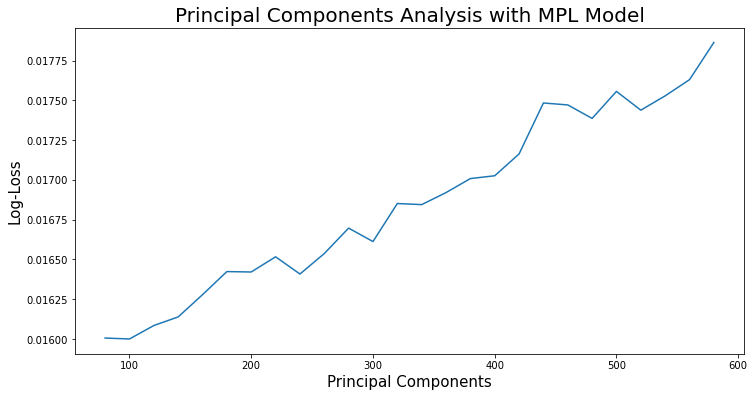

In [225]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.array(log_loss_score)[:,0], np.array(log_loss_score)[:,1])
ax.set_xlabel('Principal Components', fontsize=15)
ax.set_ylabel('Log-Loss', fontsize=15)
ax.set_title('Principal Components Analysis with MPL Model', fontsize=20)
plt.savefig('images/pca.jpg')

Will choose number of principal components 140

Try an AlexNet First do pca with optimal number of principal components

In [231]:
#np.random.seed(1000)

# Get principal components
n_components = 140
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.25, shuffle=True, random_state=1)

X_pca_train_reshaped = X_pca_train.reshape(X_pca_train.shape[0], X_pca_train.shape[1], 1)
X_pca_val_reshaped = X_pca_val.reshape(X_pca_val.shape[0], X_pca_val.shape[1], 1)
    
n_cols = X_pca_train_reshaped.shape[1]

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv1D(filters=96, input_shape=(n_cols, 1), kernel_size=5, strides=3))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

#2nd Convolutional Layer
AlexNet.add(Conv1D(filters=256, kernel_size=5, strides=1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

#3rd Convolutional Layer
AlexNet.add(Conv1D(filters=384, kernel_size=3, strides=1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv1D(filters=384, kernel_size=3, strides=1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv1D(filters=256, kernel_size=3, strides=1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling1D(pool_size=2, strides=2))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(206))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))

# Compiling the model
AlexNet.compile(optimizer=Adam(lr=0.001, decay=0.001/200), loss=BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)

#Model Summary
AlexNet.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 46, 96)            576       
_________________________________________________________________
batch_normalization_50 (Batc (None, 46, 96)            384       
_________________________________________________________________
activation_9 (Activation)    (None, 46, 96)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 23, 96)            0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 19, 256)           123136    
_________________________________________________________________
batch_normalization_51 (Batc (None, 19, 256)           1024      
_________________________________________________________________
activation_10 (Activation)   (None, 19, 256)         

In [232]:
n_cols

140

In [227]:
X_pca_train.shape, X_pca_val.shape, y_train.shape, y_val.shape

((17860, 140), (5954, 140), (17860, 206), (5954, 206))

In [ ]:
earlystp_alexnet = EarlyStopping(monitor='loss', patience=5)
filepath = 'models/alexnet'
checkpoint_alexnet = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')

history_alexnet = AlexNet.fit(
    X_pca_train_reshaped, y_train, batch_size=32,
    validation_data=(X_pca_val_reshaped, y_val),
    epochs=50,
    callbacks=[checkpoint_alexnet, earlystp_alexnet])

score = AlexNet.evaluate(X_pca_val_reshaped, y_val, verbose=0)

AlexNet.save('models/AlexNet_complete')

Epoch 1/50
559/559 [==============================] - 378s 668ms/step - loss: 0.6925 - logloss: 0.6924 - val_loss: 0.5058 - val_logloss: 0.5052
INFO:tensorflow:Assets written to: models\alexnet\assets
Epoch 2/50
559/559 [==============================] - 373s 668ms/step - loss: 0.4411 - logloss: 0.4408 - val_loss: 0.3240 - val_logloss: 0.3235
INFO:tensorflow:Assets written to: models\alexnet\assets
Epoch 3/50
559/559 [==============================] - 369s 660ms/step - loss: 0.2989 - logloss: 0.2984 - val_loss: 0.2300 - val_logloss: 0.2293
INFO:tensorflow:Assets written to: models\alexnet\assets
Epoch 4/50
559/559 [==============================] - 443s 793ms/step - loss: 0.2148 - logloss: 0.2141 - val_loss: 0.1703 - val_logloss: 0.1694
INFO:tensorflow:Assets written to: models\alexnet\assets
Epoch 5/50
559/559 [==============================] - 375s 670ms/step - loss: 0.1596 - logloss: 0.1587 - val_loss: 0.1292 - val_logloss: 0.1282
INFO:tensorflow:Assets written to: models\alexnet\as

In [105]:
random_seed = 1
n_folds = 1

kf = KFold(n_splits=n_folds, random_state=1, shuffle=True)

mltsplit = MultilabelStratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_seed)
for train_idx, val_idx in mltsplit.split(X,y):
    X_train = X[train_idx]
    X_val  = X[val_idx]
    y_train = y.values[train_idx]
    y_val  = y.values[val_idx]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)

for idx, (train_ind, test_ind) in enumerate(kf.split(X)):
    # Split into train and test
    X_train, y_train = X[train_ind], y[train_ind]
    X_cv, y_cv = X[test_ind], y[test_ind]

    # Fit estimator

    estimator.fit(X_cv_train_std, y_cv_train_std)
    # Measure performance
    y_hat_train = estimator.predict(X_cv_train_std)
    y_hat_test = estimator.predict(X_cv_test_std)
    # Calclate the error metrics
    train_cv_errors[idx] = rss(y_cv_train_std, y_hat_train)
    test_cv_errors[idx] = rss(y_cv_test_std, y_hat_test)
return train_cv_errors, test_cv_errors